<a href="https://colab.research.google.com/github/Zhalil24/BreastMRI-CNN-Classification/blob/main/InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torchvision import datasets, transforms, models
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!cp "/content/drive/MyDrive/data_set_zip/breast_mri_dataset.rar" /content/
!unrar x /content/breast_mri_dataset.rar /content/

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_7848.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_7904.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8003.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8061.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8253.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8422.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8489.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8575.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8605.jpg      78%  OK 
Extracti

In [12]:
# 1. AYARLAR VE CİHAZ YAPILANDIRMASI

DATA_DIR = '/content/breast_mri_dataset'
BATCH_SIZE = 32
NUM_EPOCHS = 10
NUM_CLASSES = 2
IMG_SIZE = 299  # InceptionV3 standart giriş boyutu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Cihaz: {device}")

Cihaz: cuda


In [13]:
# 2. DATA AUGMENTATION VE TRANSFORMASYONLAR

norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

test_val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

In [14]:
# 3. VERİ SETLERİNİN YÜKLENMESİ
full_train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'val'), transform=test_val_transform)
test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), transform=test_val_transform)

targets = full_train_dataset.targets

In [15]:
# 4. MODEL OLUŞTURMA VE KADEMELİ FINE-TUNING

def build_inception_v3():

    model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
    child_counter = 0
    for child in model.children():
        if child_counter < 11:
            for param in child.parameters():
                param.requires_grad = False
        child_counter += 1

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

    model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, NUM_CLASSES)

    return model.to(device)

In [16]:
# 5. EĞİTİM VE DEĞERLENDİRME FONKSİYONLARI
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct = 0.0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs, aux_outputs = model(images)
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        loss = loss1 + 0.4 * loss2

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)
    return running_loss / len(loader.dataset), correct.double() / len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct = 0.0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
    return running_loss / len(loader.dataset), correct.double() / len(loader.dataset)

In [17]:
# 6. 5-FOLD STRATIFIED CROSS-VALIDATION
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    print(f"\n--- FOLD {fold+1} BAŞLIYOR ---")

    train_sub = Subset(full_train_dataset, train_idx)
    val_sub = Subset(full_train_dataset, val_idx)

    train_loader = DataLoader(train_sub, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_sub, batch_size=BATCH_SIZE, shuffle=False)

    model = build_inception_v3()
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam([
        {'params': model.Mixed_6a.parameters(), 'lr': 1e-5},
        {'params': model.Mixed_7a.parameters(), 'lr': 5e-5},
        {'params': model.Mixed_7c.parameters(), 'lr': 1e-4},
        {'params': model.fc.parameters(), 'lr': 1e-3}
    ])

    history = {'train_acc': [], 'val_acc': []}
    for epoch in range(NUM_EPOCHS):
        t_loss, t_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        v_loss, v_acc = evaluate(model, val_loader, criterion)
        history['train_acc'].append(t_acc.item())
        history['val_acc'].append(v_acc.item())
        print(f"Epoch {epoch+1}: Train Acc: {t_acc:.4f} | Val Acc: {v_acc:.4f}")

    fold_results.append(history)


--- FOLD 1 BAŞLIYOR ---
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 243MB/s] 


Epoch 1: Train Acc: 0.7030 | Val Acc: 0.7608
Epoch 2: Train Acc: 0.8045 | Val Acc: 0.8375
Epoch 3: Train Acc: 0.8354 | Val Acc: 0.8538
Epoch 4: Train Acc: 0.8601 | Val Acc: 0.8832
Epoch 5: Train Acc: 0.8804 | Val Acc: 0.8720
Epoch 6: Train Acc: 0.8927 | Val Acc: 0.9040
Epoch 7: Train Acc: 0.9082 | Val Acc: 0.9067
Epoch 8: Train Acc: 0.9128 | Val Acc: 0.9171
Epoch 9: Train Acc: 0.9229 | Val Acc: 0.9290
Epoch 10: Train Acc: 0.9248 | Val Acc: 0.9251

--- FOLD 2 BAŞLIYOR ---
Epoch 1: Train Acc: 0.7005 | Val Acc: 0.7863
Epoch 2: Train Acc: 0.8119 | Val Acc: 0.8401
Epoch 3: Train Acc: 0.8447 | Val Acc: 0.8585
Epoch 4: Train Acc: 0.8658 | Val Acc: 0.8892
Epoch 5: Train Acc: 0.8768 | Val Acc: 0.8877
Epoch 6: Train Acc: 0.8958 | Val Acc: 0.9073
Epoch 7: Train Acc: 0.9019 | Val Acc: 0.9105
Epoch 8: Train Acc: 0.9149 | Val Acc: 0.9180
Epoch 9: Train Acc: 0.9184 | Val Acc: 0.9221
Epoch 10: Train Acc: 0.9270 | Val Acc: 0.9248

--- FOLD 3 BAŞLIYOR ---
Epoch 1: Train Acc: 0.7019 | Val Acc: 0.8068
Epo

In [18]:
# 7. FİNAL TEST VE METRİKLER (EN SON MODEL İLE)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

print("\n" + "="*30)
print("TEST SETİ PERFORMANS SONUÇLARI")
print(f"Accuracy:  {accuracy_score(all_labels, all_preds):.4f}")
print(f"Precision: {precision_score(all_labels, all_preds):.4f}")
print(f"Recall:    {recall_score(all_labels, all_preds):.4f}")
print(f"F1-score:  {f1_score(all_labels, all_preds):.4f}")
print(f"ROC-AUC:   {roc_auc_score(all_labels, all_probs):.4f}")


TEST SETİ PERFORMANS SONUÇLARI
Accuracy:  0.9412
Precision: 0.9649
Recall:    0.9156
F1-score:  0.9396
ROC-AUC:   0.9885


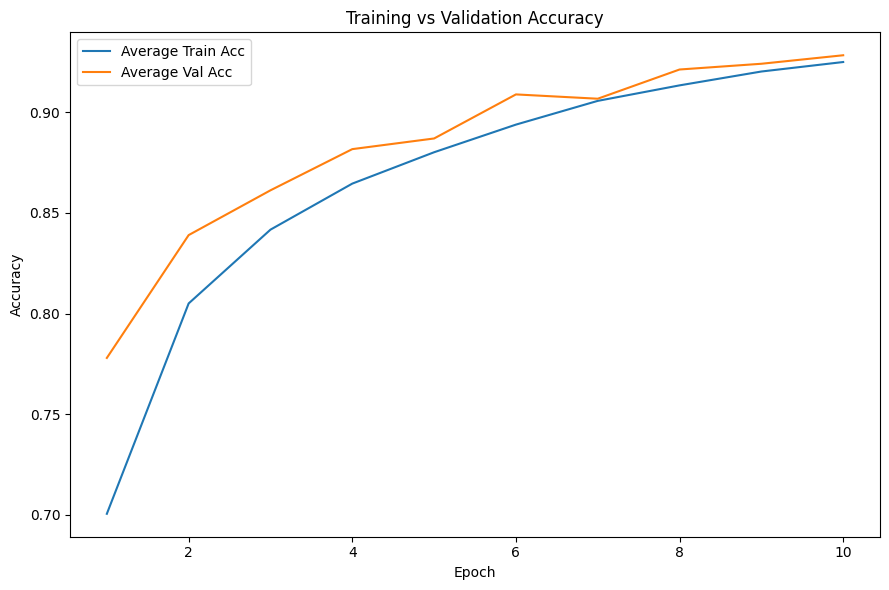

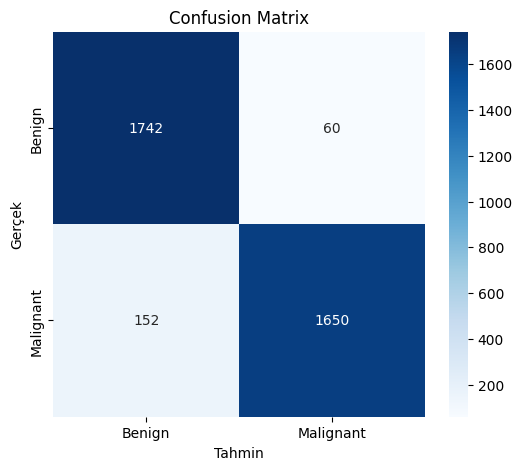

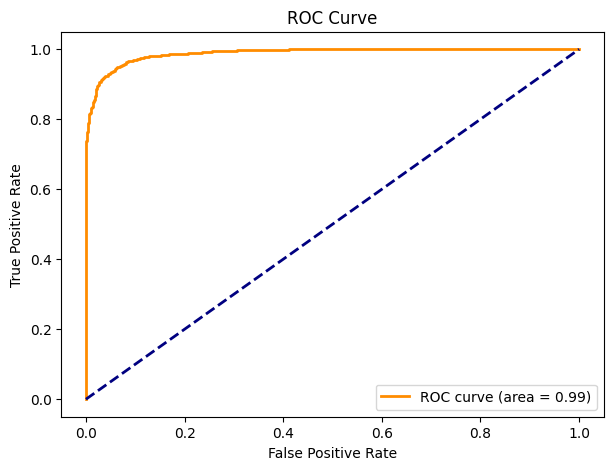

In [19]:
# 8. GÖRSELLEŞTİRME
# A. Accuracy Grafiği (Tüm foldların ortalaması)
plt.figure(figsize=(9, 6))
all_train = np.mean([f['train_acc'] for f in fold_results], axis=0)
all_val = np.mean([f['val_acc'] for f in fold_results], axis=0)
epochs = range(1, NUM_EPOCHS + 1)
plt.plot(epochs, all_train, label='Average Train Acc')
plt.plot(epochs, all_val, label='Average Val Acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# B. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.show()

# C. ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_score(all_labels, all_probs):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()